<a href="https://colab.research.google.com/github/jessecanada/MAPS/blob/master/MAPS_3_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAPS Step 3 - phenotype discovery
## This notebook will generate cell galleries by using a deep autoencoder to perform feature extraction. You will need to have cropped out individual cells in Step 2 prior to using this notebook.

### Copy images into the current session

In [ ]:
# It is recommended that you upload your cell images onto Google Drive.
# Then, the following cells will import those images for use in this
# session.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/My\ Drive/your-images.zip ./ # replace with your own file path

In [ ]:
!unzip /content/your-images.zip -d /content/

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential

Using TensorFlow backend.


### Load data & pre-processing

In [ ]:
# Grab image file names
from pathlib import Path

rootdir = Path('WT_all/')

file_list = [f for f in rootdir.glob('*.jpg') if f.is_file()]

In [ ]:
samples = []
originals = []

for fname in file_list:
    img = cv2.imread(fname.as_posix(), -1)
  
    # set blue and green channels to 0. cv2 works in BGR
    img[:, :, 0] = 0
    img[:, :, 1] = 0

    # convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    samples.append((gray/255.0).reshape(-1)) #normalize and flatten image to 1D
    originals.append(gray)

In [ ]:
df = pd.DataFrame(samples) # each row is an image, with cols being flattend 1D image array
# pad with 0
df.fillna(0, inplace=True)

In [ ]:
# any nan in the df?
df.isna().sum().sum()

0

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,36703,36704,36705,36706,36707,36708,36709,36710,36711,36712,36713,36714,36715,36716,36717,36718,36719,36720,36721,36722,36723,36724,36725,36726,36727,36728,36729,36730,36731,36732,36733,36734,36735,36736,36737,36738,36739,36740,36741,36742
0,0.031373,0.031373,0.031373,0.031373,0.031373,0.035294,0.027451,0.031373,0.035294,0.031373,0.031373,0.035294,0.031373,0.035294,0.035294,0.031373,0.035294,0.035294,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.039216,0.035294,0.039216,0.035294,0.039216,0.039216,0.043137,0.039216,0.035294,0.035294,0.039216,0.039216,0.035294,0.035294,0.035294,0.035294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.054902,0.058824,0.058824,0.058824,0.054902,0.058824,0.058824,0.054902,0.054902,0.054902,0.050980,0.054902,0.058824,0.058824,0.062745,0.054902,0.058824,0.050980,0.050980,0.054902,0.054902,0.054902,0.054902,0.058824,0.054902,0.050980,0.054902,0.058824,0.058824,0.062745,0.062745,0.062745,0.062745,0.058824,0.058824,0.062745,0.054902,0.058824,0.054902,0.054902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.054902,0.054902,0.054902,0.054902,0.054902,0.054902,0.054902,0.054902,0.050980,0.050980,0.054902,0.054902,0.054902,0.054902,0.058824,0.054902,0.054902,0.054902,0.050980,0.050980,0.050980,0.047059,0.050980,0.050980,0.050980,0.050980,0.054902,0.054902,0.050980,0.054902,0.054902,0.050980,0.050980,0.047059,0.054902,0.054902,0.050980,0.050980,0.054902,0.050980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.047059,0.050980,0.047059,0.050980,0.047059,0.047059,0.047059,0.050980,0.050980,0.054902,0.050980,0.050980,0.047059,0.047059,0.050980,0.050980,0.050980,0.058824,0.050980,0.054902,0.054902,0.054902,0.054902,0.050980,0.050980,0.050980,0.054902,0.050980,0.054902,0.050980,0.050980,0.050980,0.054902,0.050980,0.054902,0.050980,0.050980,0.054902,0.050980,0.050980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### deep autoencoder with one hidden layer

In [ ]:
# input placeholder
input_layer = Input(shape = (df.shape[1],))
# generate the encoded representation of the input
encoded = Dense(1280, activation = 'relu')(input_layer) # reduce to 64 dimensions
encoded = Dense(640, activation = 'relu')(encoded)
encoded = Dense(32)(encoded) # hidden layer, features extracted from here
# generate the lossy reconstruction of the input
decoded = Dense(640, activation = 'relu')(encoded)
decoded = Dense(1280, activation = 'relu')(decoded)
decoded = Dense(df.shape[1], activation = 'softmax')(decoded)
# build a model that maps an input to its reconstruction
deep_autoencoder = Model(input_layer, decoded)
deep_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

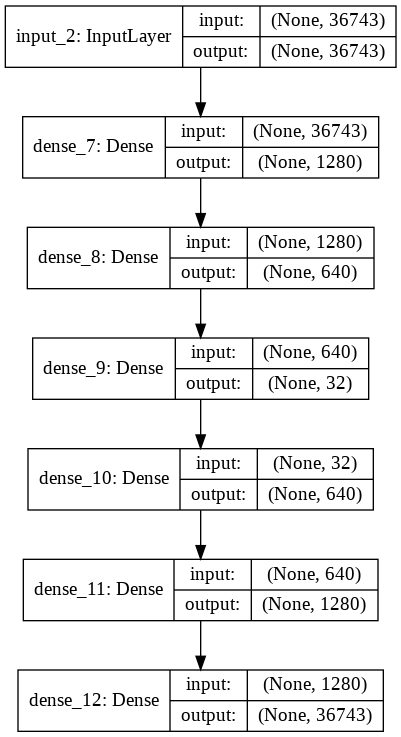

In [ ]:
from keras.utils import plot_model
plot_model(deep_autoencoder, show_shapes=True,
           to_file='deep_autoencoder_model.png')

In [ ]:
deep_autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 36743)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1280)              47032320  
_________________________________________________________________
dense_8 (Dense)              (None, 640)               819840    
_________________________________________________________________
dense_9 (Dense)              (None, 32)                20512     
_________________________________________________________________
dense_10 (Dense)             (None, 640)               21120     
_________________________________________________________________
dense_11 (Dense)             (None, 1280)              820480    
_________________________________________________________________
dense_12 (Dense)             (None, 36743)             4706

In [ ]:
from keras.callbacks import TensorBoard

deep_autoencoder.fit(df, df,
                epochs=50,
                batch_size=100,
                validation_data=(df, df),
                verbose=1,
                callbacks=[TensorBoard(log_dir='/content/autoencoder_log')])

# define a placeholder for the encoded input (64 dimensions)
encoder = Model(input_layer, encoded)
# create the encoded input on df
Xe = encoder.predict(df)

Train on 1031 samples, validate on 1031 samples
Epoch 1/50
1031/1031 [==============================] - 22s 21ms/step - loss: 0.1813 - val_loss: 0.1808
Epoch 2/50
 700/1031 [===================>..........] - ETA: 5s - loss: 0.1741

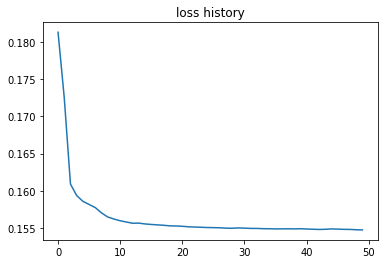

In [ ]:
# Look at the training performance
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('loss history')
plt.plot(autoencoder.history.history['loss'])
plt.show()

### Generate cell galleries

In [ ]:
# t-SNE

from sklearn.manifold import TSNE
import timeit
start = timeit.default_timer()

# default perplexity=30, n_iter=1000, init='random'
tsne_Xe = TSNE(n_components=2, perplexity=80, 
               n_iter=2000, init='pca').fit_transform(Xe)

stop = timeit.default_timer()

print(f'run time = {(stop-start):.2f}s')

run time = 7.42s


In [ ]:
# spectral clustering
# on the encoder output, not the tSNE output
from sklearn.cluster import SpectralClustering

# Building the clustering model 
spectral_model_nn = SpectralClustering(n_clusters=4, affinity='nearest_neighbors') 
  
# Training the model and Storing the predicted cluster labels 
labels_nn = spectral_model_nn.fit_predict(Xe)


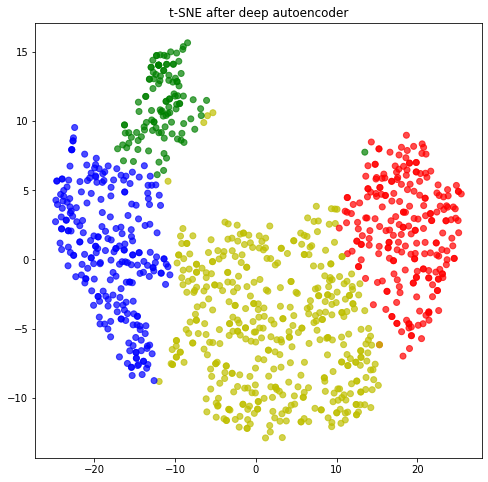

In [ ]:
# 2D plot of spectral clustering

# Building the label to colour mapping 
colours = {} 
colours[0] = 'b'
colours[1] = 'y'
colours[2] = 'r'
colours[3] = 'g'
  
# Building the colour vector for each data point 
#cvec = [colours[label] for label in labels_nn] 
cvec = [colours[label] for label in labels_nn] 

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(tsne_Xe[:,0], tsne_Xe[:,1], marker='o', c=cvec, alpha=0.7)
ax.set_title('t-SNE after deep autoencoder')
plt.show(); plt.close()

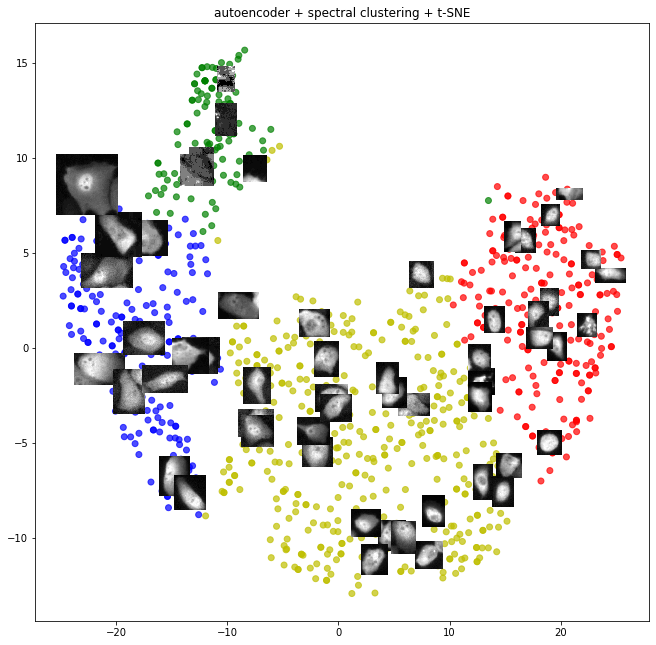

In [ ]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Plotting the scatter plot and show images
fig, ax = plt.subplots(1,1, figsize =(11, 11)) 
ax.scatter(tsne_Xe[:,0], tsne_Xe[:,1], marker='o', c=cvec, alpha=0.7)
ax.set_title('autoencoder + spectral clustering + t-SNE')

# plot random images
num_to_plot = 60
num_images = len(df)
x=0; y=1

for i in range(num_to_plot):
    img_num = int(random.random() * num_images)
    
    x = tsne_Xe[img_num,0]
    y = tsne_Xe[img_num,1]
    #print((x0, x1, y0, y1))
    imbox = OffsetImage(originals[img_num], zoom=0.35, cmap='gray')
    ab = AnnotationBbox(imbox, (x,y), xycoords='data', frameon=False)
    ax.add_artist(ab)
    

plt.show()
plt.close()